In [47]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, KFold


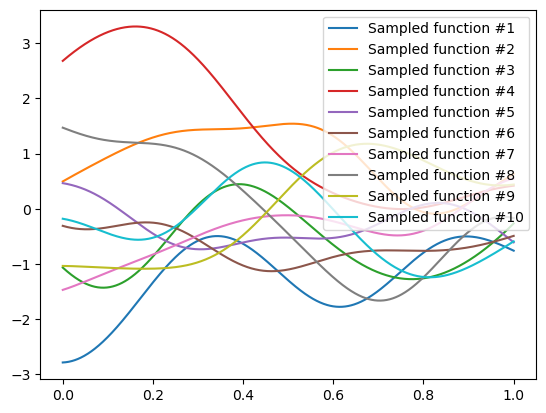

In [4]:
kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-1,10.0))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=2)

N = 31 * 29 + 1
t = np.linspace(0,1,N)
dt = t[1]-t[0]

X = t.reshape(-1, 1)
n_samples=10

y_samples = gpr.sample_y(X, n_samples)

plt.figure()
for idx, single_prior in enumerate(y_samples.T):
    plt.plot(
        t,
        single_prior,
        # linestyle="--",
        # alpha=0.7,
        label=f"Sampled function #{idx + 1}",
    )

plt.legend()

forcing_terms = y_samples.T

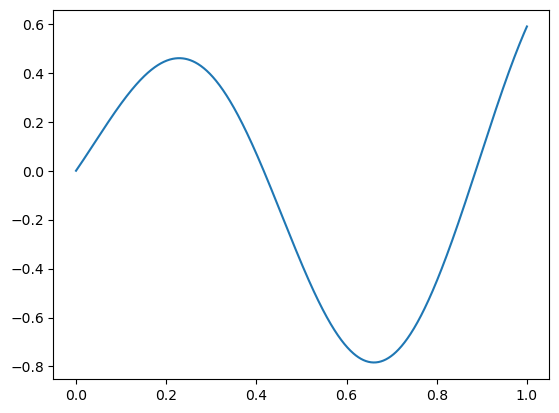

In [5]:
dt = t[1]-t[0]
    
def f(t,u, force):
    k = 9.81/0.2
    u0 = u[1]
    u1 = -k*np.sin(u[0]) + force[int(t/dt)]
    U = np.array([u0, u1])
    return U

plt.figure()
# for ft in forcing_terms:
#     sol = scipy.integrate.solve_ivp(lambda t, y: f(t,y,ft), y0=[0,0], t_span=[0,1],t_eval=t)
#     plt.plot(sol.t, sol.y[1])
sol = scipy.integrate.solve_ivp(lambda t, y: f(t,y,forcing_terms[3]), y0=[0,0], t_span=[0,1],t_eval=t)
plt.plot(sol.t, sol.y[1])

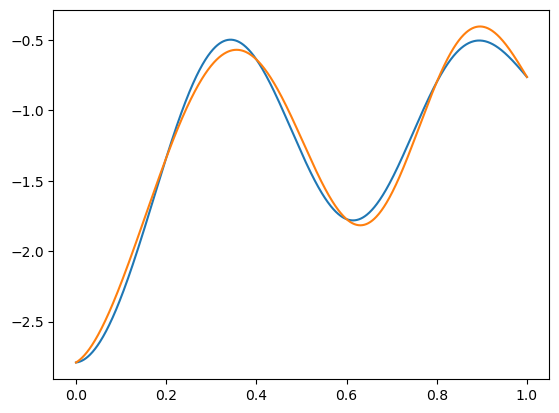

In [6]:
plt.plot(t,forcing_terms[0])
beta = 0.1
plt.plot(t, forcing_terms[0] +  beta * np.sin(5 * np.pi * t))

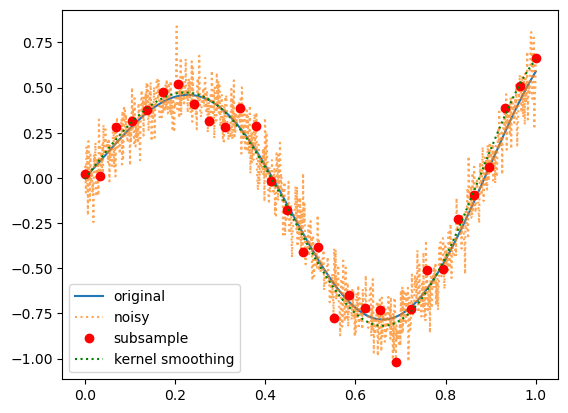

In [7]:
ut = sol.y[1]
noise = np.random.normal(0,0.1,N)
ut_perturbed = ut + noise

u_sample = ut_perturbed[::31]
t_sample = t[::31]

T_train = t_sample.reshape(-1,1)

UXX = rbf_kernel(T_train, T_train, gamma=1)

lam = 1e-4
UXX_inv_u = np.linalg.solve(UXX + lam**2*np.eye(30), u_sample)
T_test = t.reshape(-1,1)
UxX = rbf_kernel(T_test, T_train, gamma=1)
smoothed = UxX @ UXX_inv_u

plt.figure()
plt.plot(t, ut, '-', label='original')
plt.plot(t, ut_perturbed, ':', alpha=0.7, label='noisy')
plt.plot(t_sample, u_sample,'ro', label='subsample')
plt.plot(t, smoothed, 'g:', label='kernel smoothing')
plt.legend()
plt.show()

In [8]:
data = []
t_sample = t[::31]
for ft in forcing_terms:
    sol = scipy.integrate.solve_ivp(lambda t, y: f(t,y,ft), y0=[0,0], t_span=[0,1],t_eval=t)
    u = sol.y[0]
    ut = sol.y[1]
    noise = np.random.normal(0,0.1,N)
    ut_perturbed = ut + noise
    u_perturbed = u + noise

    ut_sample = ut_perturbed[::31]
    u_sample = u_perturbed[::31]

    data.append([u_sample, ut_sample, t_sample])

data = np.array(data)
data.shape

(10, 3, 30)

In [243]:
# pendulum
def Kt(X, Y, col, l):
    # K = rbf_kernel(X,Y, gamma)
    K = RBF(length_scale=l)
    coeff = -2 * l * (X[:,col:col+1] - Y[:, col:col+1].T)
    return coeff * K(X, Y)

def Ktt(X, Y, col, gamma):
    K = rbf_kernel(X,Y, gamma)
    coeff = 2 * gamma * ( 2* gamma (X[:,col:col+1] - Y[:, col:col+1].T) ** 2 -1)
    return coeff * K

X = np.array([[1,2]]).T
Y = np.array([[3,4,5,6]]).T
s1 = Kt(X,Y,0, 1)
print(s1)

[[5.41341133e-01 6.66539792e-02 2.68370102e-03 3.72665317e-05]
 [1.21306132e+00 5.41341133e-01 6.66539792e-02 2.68370102e-03]]


In [231]:
ut = sol.y[1]
u = sol.y[0]
noise = np.random.normal(0,0.01,N)
u_perturbed = u + noise
u_t_perturbed = ut + noise

scaler = StandardScaler()

t_sample = t[::31]
u_sample = u_perturbed[::31]
u_t_sample = u_t_perturbed[::31]

0.01 1.0
0.11 1.00030775989067
0.21000000000000002 0.9882866748138946
0.31000000000000005 3.376831279462022
0.41000000000000003 29.425847130174162
0.51 10.372344741045845
0.6100000000000001 3.157602379542207
0.7100000000000001 7.112918405286466
0.81 1.8070672734672386
0.91 2.3554838214368248
1.01 1.7317257926537173
1.11 1.7602620928200097
1.2100000000000002 2.5697531639583895
1.31 3.86424983888418
1.4100000000000001 5.239232288198499
1.51 6.885992846346383
1.61 8.925519714978261
1.7100000000000002 12.42589725780969
1.81 17.68493227910066
1.9100000000000001 25.599059050452446
lowest gamma 0.21000000000000002
0.9882866748138946


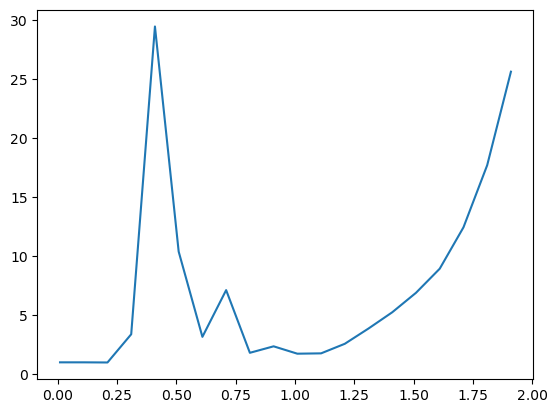

In [238]:

u_true_sample = u[::31]

def relative_error(f,y):
    return ((f-y).T@(f-y))/(y.T@y)

def smooth(x_train, y_train, eta, gamma):
    UXX = rbf_kernel(x_train, x_train, gamma=gamma)
    UXX_nugget = (UXX + eta ** 2 * np.eye(x_train.shape[0]))
    def u(x_test):
        UxX_test = rbf_kernel(x_test, x_train, gamma=gamma)
        return UxX_test @ np.linalg.solve(UXX_nugget, y_train)
    return u

def smoothDif(x_train, y_train, eta, l):
    K = RBF(length_scale=l)
    UXX = K(x_train, x_train)
    UXX_nugget = (UXX + eta ** 2 * np.eye(x_train.shape[0]))
    def u(x_test):
        UxX_test = Kt(x_test, x_train, 0, l)
        return UxX_test @ np.linalg.solve(UXX_nugget, y_train)
    return u

errs = []
errs_t = []
cv = ShuffleSplit(n_splits=10, random_state=0)

g_range = np.arange(0.01,2, 0.1)
for g in g_range:
    err = 0
    err_t = 0
    eta = 1e-7
    T = t_sample.reshape(-1,1)
    for train, test in cv.split(T):
        scaler = StandardScaler()
        y_train = u_sample[train]
        x_train = T[train]
        x_train_scaled = scaler.fit_transform(x_train)
        y_test = u_t_sample[test]
        x_test = T[test]
        x_test_scaled = scaler.transform(x_test)
        u_t_star = smoothDif(x_train_scaled,y_train,eta,g)
        err_t += relative_error(u_t_star(x_test_scaled), y_test)
    # errs.append(err/10)
    errs_t.append(err_t/10)
    print(g, err_t/10)

lowest_index = errs_t.index(min(errs_t))
print('lowest gamma', g_range[lowest_index])
print(min(errs_t))

# plt.plot(g_range, errs)
plt.plot(g_range, errs_t)

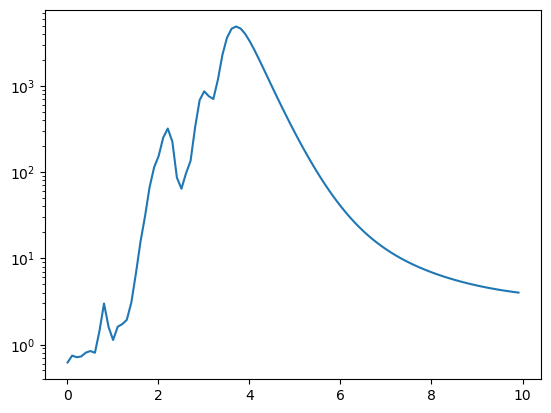

In [183]:
plt.semilogy(g_range, errs_t)

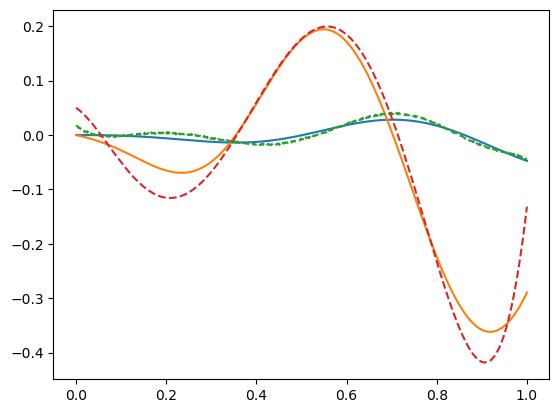

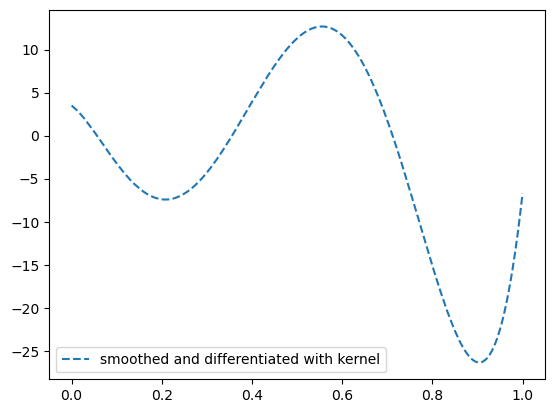

In [244]:
gamma = 0.05
lam = 1e-7

T_train = t_sample.reshape(-1,1)
T_train_scaled = scaler.fit_transform(T_train)
UXX = rbf_kernel(T_train_scaled, T_train_scaled, gamma=gamma)

UXX_inv_u = np.linalg.solve(UXX + lam**2*np.eye(len(UXX)), u_sample)

T_test = t.reshape(-1,1)
T_test_scaled = scaler.transform(T_test)
UxX = rbf_kernel(T_test_scaled, T_train_scaled, gamma=gamma)
smoothed = UxX @ UXX_inv_u

T = t.reshape(-1,1)

gamma_t = 0.05
lam_t = 1e-7

UXX_t = rbf_kernel(T_train, T_train, gamma=gamma_t)
UXX_inv_u_t = np.linalg.solve(UXX_t + lam_t**2*np.eye(len(UXX_t)), u_sample)

K = rbf_kernel(T_test,T_train, gamma_t)
coeff = -2 * gamma_t * (T_test - T_train.T)
kt = coeff * K
UxX_t = kt
smoothed_t = UxX_t @ UXX_inv_u_t

plt.plot(t,u, label='u')
plt.plot(t,ut,label='ut')
plt.plot(t,smoothed,'--',label='smoothed with kernel')
plt.plot(t,smoothed_t,'--',label='smoothed and differentiated with kernel')

plt.figure()
smoothed_t = smoothDif(T_train,u_sample, lam_t, 1 / np.sqrt(2 * gamma_t))(T_test)
plt.plot(t,smoothed_t,'--',label='smoothed and differentiated with kernel')


plt.legend()